In [6]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
import zipfile,os
local_zip = '/content/gdrive/My Drive/DataSetFaceMask/FaceMask.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [12]:
base_dir = '/tmp/FaceMask'

file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [13]:
import pandas as pd
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
new_with_mask       10000
new_without_mask    10000
dtype: int64

In [15]:
from sklearn.model_selection import train_test_split

X = df['path']
y = df['tag']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=300)

df_tr = pd.DataFrame({'path':X_train, 'tag':y_train, 'set':'train'})
df_val = pd.DataFrame({'path':X_val, 'tag':y_val, 'set':'validation'})

print('train size', len(df_tr))
print('val size', len(df_val))

df_all = df_tr.append([df_val]).reset_index(drop=1)
print(df_all.groupby(['set','tag']).size(),'\n')

df_all.sample(5)

train size 16000
val size 4000
set         tag             
train       new_with_mask       7992
            new_without_mask    8008
validation  new_with_mask       2008
            new_without_mask    1992
dtype: int64 



,path,tag,set
17559,/tmp/FaceMask/new_without_mask/seed3345.png,new_without_mask,validation
11844,/tmp/FaceMask/new_with_mask/with-mask-default-...,new_with_mask,train
15204,/tmp/FaceMask/new_without_mask/seed6578.png,new_without_mask,train
12106,/tmp/FaceMask/new_without_mask/seed6873.png,new_without_mask,train
19535,/tmp/FaceMask/new_without_mask/seed8808.png,new_without_mask,validation


In [16]:
import shutil
from tqdm.notebook import tqdm as tq

datasource_path = "/tmp/FaceMask/"
dataset_path = "/tmp/dataset_FaceMask/"

for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

In [17]:
train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'validation')

In [19]:
os.listdir(train_dir)

['new_with_mask', 'new_without_mask']

In [20]:
os.listdir(validation_dir)

['new_with_mask', 'new_without_mask']

In [21]:
train_withMask_dir = os.path.join(train_dir, 'with_mask')
train_withoutMask_dir = os.path.join(train_dir, 'without_mask')

validation_withMask_dir = os.path.join(validation_dir, 'with_mask')
validation_withoutMask_dir = os.path.join(validation_dir, 'without_mask')

In [22]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [23]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2592)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1327616   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

In [25]:
# Callback Function
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.92 and logs.get('val_acc')>0.92):
      print("\nAkurasi pada training set dan validation set telah mencapai > 92%")
      self.model.stop_training = True
callbacks = myCallback()

In [26]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=3,
      verbose=2,
      callbacks=[callbacks])

Epoch 1/10
25/25 - 2s - loss: 0.7117 - acc: 0.6200 - val_loss: 0.7098 - val_acc: 0.3333
Epoch 2/10
25/25 - 1s - loss: 0.6445 - acc: 0.6200 - val_loss: 0.5310 - val_acc: 0.9167
Epoch 3/10
25/25 - 2s - loss: 0.5055 - acc: 0.8100 - val_loss: 1.2822 - val_acc: 0.5833
Epoch 4/10

Akurasi pada training set dan validation set telah mencapai > 92%
25/25 - 1s - loss: 0.3591 - acc: 0.9200 - val_loss: 0.0760 - val_acc: 1.0000


In [27]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

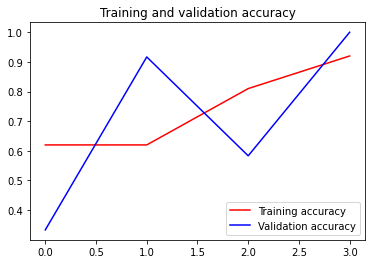

<Figure size 432x288 with 0 Axes>

In [28]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

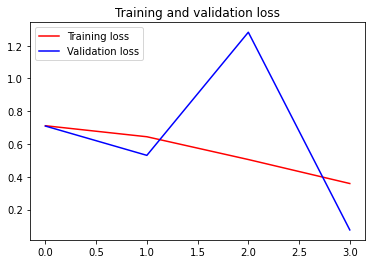

<Figure size 432x288 with 0 Axes>

In [29]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [30]:
# Writes code to save the model in TF-Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpkdzhs_ex/assets


In [31]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)